In [1]:
# For the notebook to work you must have m3_learning installed
# pip install m3_learning
%load_ext autoreload
%autoreload 2

import numpy as np

from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.util.file_IO import download_and_unzip
from m3_learning.viz.printing import printer
from m3_learning.be.viz import Viz
from m3_learning.be.dataset import BE_Dataset
from IPython.display import Video


# from m3_learning.be.dataset import BE_Dataset
printing = printer(basepath = './Figures/')

set_style("printing")
random_seed(seed=42)

%matplotlib inline


2024-02-12 10:44:51.701696: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-12 10:44:52.223382: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ferroelectric/micromamba/envs/paper/lib/python3.10/site-packages/cv2/../../lib64:
2024-02-12 10:44:52.223431: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ferroelectric/micromamba/envs/paper/

printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


In [2]:
import sys

sys.path.append("../../")
# sys.path.append("/home/ferroelectric/Documents/m3_learning/m3_learning/src")
sys.path.append('../../src')

## Loading data for SHO fitting


In [3]:
# Download the data file from Zenodo
url = 'https://zenodo.org/record/7774788/files/PZT_2080_raw_data.h5?download=1'

# Specify the filename and the path to save the file
filename = '/data_raw_unmod.h5'
save_path = './Data'

# download the file
download_and_unzip(filename, url, save_path)

Using files already downloaded


In [4]:
data_path = save_path + '/' + filename

# instantiate the dataset object
dataset = BE_Dataset(data_path)

# print the contents of the file
dataset.print_be_tree()

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values


/home/ferroelectric/micromamba/envs/paper/lib/python3.10/site-packages/m3_learning/util/preprocessing.py:43: RuntimeWarning: invalid value encountered in divide
  return (data - self.mean)/self.std


/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Noisy_Data_1
    ├ Noisy_Data_2
    ├ Noisy_Data_3
    ├ Noisy_Data_4
    ├ Noisy_Data_5
    ├ Noisy_Data_6
    ├ Noisy_Data_7
    ├ Noisy_Data_8
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spatially_Averaged_Plot_Group_001
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS
    ├ UDVS_Indices
├ Noisy_Data_1_SHO_Fit
  --------

In [16]:
import os
import re
import csv
from m3_learning.nn.Fitter1D.Fitter1D import Multiscale1DFitter, Model
from m3_learning.nn.Fitter1D.Fitter1D import ComplexPostProcessor
from m3_learning.be.nn import SHO_fit_func_nn
import pandas as pd



class InferenceEvaluation:
    
    def __init__(self, dataset, folder, csv_file):
        self.folder = folder
        self.csv_file = csv_file
        self.load_from_csv()
        self.dataset = dataset
        
    def load_from_csv(self):
        
        # Initialize an empty list to store all rows of data
        data_list = []

        # Open and read the CSV file
        with open(self.csv_file, 'r') as file:
            csvreader = csv.reader(file)
            next(csvreader, None)  # Skip the header row (if any
            
            # Iterate over each row in the csv file
            for row in csvreader:
                # Assuming each row follows the structure you provided
                model_name = row[0]
                i = int(row[1])
                optimizer_name = row[2]
                noise = row[3]
                
                epochs = int(row[4])
                total_time = float(row[5])
                train_loss = float(row[6])
                batch_size = int(row[7])
                loss_func = row[8]
                seed = int(row[9])
                model_path = row[10]  # This already includes the path with the filename
                stoppage_early = row[11]  # Assuming this is a string that needs to be interpreted
                model_updates = int(row[12])
                
                # Append this row of data as a dictionary (or any other structure you prefer) to your list
                data_list.append({
                    'model_name': model_name,
                    'i': i,
                    'noise': noise,
                    'optimizer_name': optimizer_name,
                    'epochs': epochs,
                    'total_time': total_time,
                    'train_loss': train_loss,
                    'batch_size': batch_size,
                    'loss_func': loss_func,
                    'seed': seed,
                    'stoppage_early': stoppage_early == "True", # Convert to boolean 
                    'model_updates': model_updates
                })
                
        self.data_list = data_list
        
    def get_file(self, data):
        for filename in os.listdir(self.folder):
            
            if data['stoppage_early']:
                pattern = rf'Early_Stoppage_at_{data["total_time"]}_{data["model_name"]}_model_optimizer_{data["optimizer_name"]}_epoch_{data["epochs"]}_train_loss_{data["train_loss"]}.pth'
                match = re.match(pattern, filename)
                
            else:
                pattern = rf'{data["model_name"]}_model_optimizer_{data["optimizer_name"]}_epoch_{data["epochs"]}_train_loss_{data["train_loss"]}.pth'
                match = re.match(pattern, filename)
            
            if match:
                data['filename'] = filename
                return filename
            
    def get_reference_data(self, noise_state):
        self.dataset.noise = noise_state

        # extracts the x and y data based on the noise
        self.x_reference, self.y_reference = self.dataset.NN_data()
    
    def load_model(self, model_path):
        
        postprocessor = ComplexPostProcessor(self.dataset)


        model_ = Multiscale1DFitter(SHO_fit_func_nn,  # function
                                    self.dataset.frequency_bin,  # x data
                                    2,  # input channels
                                    4,  # output channels
                                    self.dataset.SHO_scaler,
                                    postprocessor)

        # instantiate the model
        model = Model(model_, dataset, training=False)
        
        model.load(model_path)
        
        return model

In [17]:
filepath = "/home/ferroelectric/Documents/m3_learning/m3_learning/papers/2023_Rapid_Fitting/Trained Models/SHO Fitter/2023-12-12_11-36-09_nn_benchmarks_noise"
csv_file = "/home/ferroelectric/Documents/m3_learning/m3_learning/papers/2023_Rapid_Fitting/Trained Models/SHO Fitter/2023-12-12_11-36-09_nn_benchmarks_noise/Batch_Training_SpeedTest.csv"

evaluation = InferenceEvaluation(dataset, filepath, csv_file)

evaluation.get_file(evaluation.data_list[0])

'SHO_Fitter_original_data_model_optimizer_Adam_epoch_4_train_loss_0.03396249711867885.pth'

In [18]:
evaluation.data_list[0]

{'model_name': 'SHO_Fitter_original_data',
 'i': 0,
 'noise': '0',
 'optimizer_name': 'Adam',
 'epochs': 4,
 'total_time': 93.67418122291565,
 'train_loss': 0.03396249711867885,
 'batch_size': 500,
 'loss_func': 'MSELoss()',
 'seed': 0,
 'stoppage_early': False,
 'model_updates': 11060,
 'filepath': 'SHO_Fitter_original_data_model_optimizer_Adam_epoch_4_train_loss_0.03396249711867885.pth'}

In [14]:

df = pd.read_csv(csv_file)
df['basename'] = df['filename'].apply(os.path.basename)

In [15]:
df.keys()

Index(['Model Name', ' Noise', ' Optimizer', ' Training Number', ' Epochs',
       'Training_Time', 'Train Loss', 'Batch Size', 'Loss Function', 'Seed',
       'filename', 'early_stoppage', 'model updates', 'basename'],
      dtype='object')

In [4]:
folder_path = "/home/ferroelectric/Documents/m3_learning/m3_learning/papers/2023_Rapid_Fitting/Trained Models/SHO Fitter/2023-12-12_11-36-09_nn_benchmarks_noise"


def extract_number(filename):
    match = re.search(r'(\d+\.\d+)$', filename)
    return match.group(1) if match else None

# List and process all files in the folder
folder_files = [f for f in os.listdir(
    folder_path) if os.path.isfile(os.path.join(folder_path, f))]
extracted_numbers_in_folder = [extract_number(f) for f in folder_files]

# Count the number of extracted numbers in DataFrame not present in folder
missing_count = sum(
    1 for number in df['Train Loss'] if number not in extracted_numbers_in_folder)

print(f"Number of files in DataFrame missing in folder: {missing_count}")

Number of files in DataFrame missing in folder: 594


In [5]:
import sys

sys.path.append("../../")
# sys.path.append("/home/ferroelectric/Documents/m3_learning/m3_learning/src")
sys.path.append('../../src')

## Loading data for SHO fitting


In [7]:
# Download the data file from Zenodo
url = 'https://zenodo.org/record/7774788/files/PZT_2080_raw_data.h5?download=1'

# Specify the filename and the path to save the file
filename = '/data_raw_unmod.h5'
save_path = './Data'

# download the file
download_and_unzip(filename, url, save_path)

Using files already downloaded


In [8]:
data_path = save_path + '/' + filename

# instantiate the dataset object
dataset = BE_Dataset(data_path)

# print the contents of the file
dataset.print_be_tree()

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values


/home/ferroelectric/micromamba/envs/paper/lib/python3.10/site-packages/m3_learning/util/preprocessing.py:43: RuntimeWarning: invalid value encountered in divide
  return (data - self.mean)/self.std


/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Noisy_Data_1
    ├ Noisy_Data_2
    ├ Noisy_Data_3
    ├ Noisy_Data_4
    ├ Noisy_Data_5
    ├ Noisy_Data_6
    ├ Noisy_Data_7
    ├ Noisy_Data_8
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spatially_Averaged_Plot_Group_001
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS
    ├ UDVS_Indices
├ Noisy_Data_1_SHO_Fit
  --------

In [9]:
# insatiate the visualization object
image_scalebar = [2000, 500, "nm", "br"]

BE_viz = Viz(dataset, printing, verbose=True,
             SHO_ranges=[(0, 1.5e-4), (1.31e6, 1.33e6),
                         (-300, 0), (-np.pi, np.pi)],
             image_scalebar=image_scalebar)

# extracts the x and y data based on the noise
X_data_no_noise, Y_data = dataset.NN_data()


        Dataset = Raw_Data
        Resample = False
        Raw Format = complex
        fitter = LSQF
        scaled = False
        Output Shape = pixels
        Measurement State = all
        Resample Resampled = False
        Resample Bins = 165
        LSQF Phase Shift = None
        NN Phase Shift = None
        Noise Level = 0
        loop interpolated = False
                    
None


In [10]:
dataset.noise = 0

# extracts the x and y data based on the noise
X_data_no_noise, Y_data = dataset.NN_data()


        Dataset = Raw_Data
        Resample = False
        Raw Format = complex
        fitter = LSQF
        scaled = False
        Output Shape = pixels
        Measurement State = all
        Resample Resampled = False
        Resample Bins = 165
        LSQF Phase Shift = None
        NN Phase Shift = None
        Noise Level = 0
        loop interpolated = False
                    
None


In [11]:
dataset.noise = 5

# extracts the x and y data based on the noise
X_data_noise, Y_data = dataset.NN_data()


        Dataset = Noisy_Data_5
        Resample = False
        Raw Format = complex
        fitter = LSQF
        scaled = False
        Output Shape = pixels
        Measurement State = all
        Resample Resampled = False
        Resample Bins = 165
        LSQF Phase Shift = None
        NN Phase Shift = None
        Noise Level = 5
        loop interpolated = False
                    
None


In [12]:
import torch
import torch.nn.functional as F

mse = F.mse_loss(X_data_noise, X_data_no_noise, reduction='mean')

In [13]:
mse

tensor(16.6775)

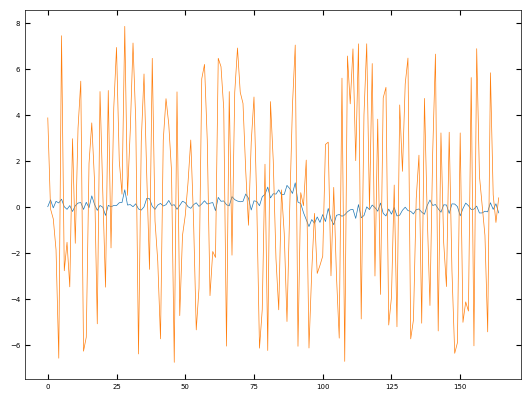

In [14]:
import matplotlib.pyplot as plt

i = np.random.randint(0, X_data_no_noise.shape[0])


plt.plot(X_data_no_noise[i, :, 0])
plt.plot(X_data_noise[i, :, 0])

Using GPU NVIDIA GeForce RTX 3090


In [16]:
model.load("/home/ferroelectric/Documents/m3_learning/m3_learning/papers/2023_Rapid_Fitting/Trained Models/SHO Fitter/2023-12-12_11-36-09_nn_benchmarks_noise/SHO_Fitter_original_data_model_epoch_4_train_loss_23.801016445720084.pth")
noise_output = model.predict(X_data_noise)
mse = F.mse_loss(noise_output[0], X_data_no_noise, reduction='mean')

FileNotFoundError: [Errno 2] No such file or directory: '/home/ferroelectric/Documents/m3_learning/m3_learning/papers/2023_Rapid_Fitting/Trained Models/SHO Fitter/2023-12-12_11-36-09_nn_benchmarks_noise/SHO_Fitter_original_data_model_epoch_4_train_loss_23.801016445720084.pth'

In [56]:
data = [model_name,
        i,
        noise,
        optimizer_name,
        epochs,
        total_time,
        train_loss,
        batch_size,
        loss_func,
        seed,
        f"{path}/{model_name}_model_epoch_{epochs}_train_loss_{train_loss}.pth",
        f"{stoppage_early}",
        f"{model_updates}"]

tensor(1.9819)

In [43]:
for i in range(len(df)):
    print(df['filename'][i])
    

Trained Models/SHO Fitter//2023-12-12_11-36-09_nn_benchmarks_noise//SHO_Fitter_original_data_model_epoch_4_train_loss_0.03396249711867885.pth
Trained Models/SHO Fitter//2023-12-12_11-36-09_nn_benchmarks_noise//SHO_Fitter_original_data_model_epoch_4_train_loss_0.03395258604763916.pth
Trained Models/SHO Fitter//2023-12-12_11-36-09_nn_benchmarks_noise//SHO_Fitter_original_data_model_epoch_4_train_loss_0.03393520742159766.pth
Trained Models/SHO Fitter//2023-12-12_11-36-09_nn_benchmarks_noise//SHO_Fitter_original_data_model_epoch_4_train_loss_0.034048735572165846.pth
Trained Models/SHO Fitter//2023-12-12_11-36-09_nn_benchmarks_noise//SHO_Fitter_original_data_model_epoch_4_train_loss_0.034134297015380406.pth
Trained Models/SHO Fitter//2023-12-12_11-36-09_nn_benchmarks_noise//SHO_Fitter_original_data_model_epoch_4_train_loss_0.034055540985449356.pth
Trained Models/SHO Fitter//2023-12-12_11-36-09_nn_benchmarks_noise//SHO_Fitter_original_data_model_epoch_4_train_loss_0.034248754261675965.pth
Tr